In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
import os
import time
from tqdm import tqdm
from datetime import datetime, timedelta, date
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator
start_time = time.perf_counter()

In [13]:
table = pd.read_csv('value_raw_data_latest.csv')
table['Date'] = pd.to_datetime(table['Date'])
price_data = pd.read_csv('stockPriceData-3.csv')
price_data=price_data[price_data['Date']>='2006']
price_data.drop_duplicates(['Date','Symbol'],inplace=True)
price_data['Date'] = pd.to_datetime(price_data['Date'])
table = pd.merge(price_data,table, on= ['Date','Symbol'])

In [14]:
# Filter top 500 companies by market cap for each date
table = table.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))

# Keep only the relevant columns
table = table[['Date', 'Symbol', 'PB', 'PE','Mcap']]

# Replace non-positive values with NaN for factors
factor = ['PB', 'PE']
table[factor] = table[factor].where(table[factor] > 0, np.nan)

# Calculate mean and standard deviation for each factor grouped by date
table['mean_PB'] = table.groupby('Date')['PB'].transform('mean')
table['mean_PE'] = table.groupby('Date')['PE'].transform('mean')
table['STD_PB'] = table.groupby('Date')['PB'].transform('std')
table['STD_PE'] = table.groupby('Date')['PE'].transform('std')

# Calculate inverted Z-Scores (higher values -> lower Z-scores)
table['Z_PE'] = -(table['PE'] - table['mean_PE']) / table['STD_PE']
table['Z_PB'] = -(table['PB'] - table['mean_PB']) / table['STD_PB']

# Calculate Weighted Average Z-Score
table['WeightedAvgZ'] = ((1/2) * table['Z_PE']) + ((1/2) * table['Z_PB'])

# Calculate Normalized Value Score
table['Value_score_cross'] = np.where(table['WeightedAvgZ'] >= 0,
                                1 + table['WeightedAvgZ'], 
                                (1 - table['WeightedAvgZ'])**-1)

# Filter, rank, and finalize the table
table = table[['Date', 'Symbol', 'Value_score_cross', 'PB', 'PE', 'Mcap']].reset_index(drop=True)
table['Value_cross_rank'] = table.groupby('Date', group_keys=False)['Value_score_cross'].apply(lambda x: x.rank(pct=True, ascending=True))

In [15]:
# Filter top 500 companies by market cap for each date
table = table.groupby('Date', group_keys=False).apply(
    lambda x: x.sort_values(by='Mcap', ascending=False).head(500)
)
# Keep only relevant columns
table = table[['Date', 'Symbol', 'PB', 'PE','Mcap','Value_score_cross','Value_cross_rank']]

# Replace non-positive values with NaN for factors
factors = ['PB', 'PE']
table[factors] = table[factors].where(table[factors] > 0, np.nan)

# Merge with sector mapping data
SectorThemeGICS = pd.read_excel('SectorMapping.xlsx')
table = pd.merge(table, SectorThemeGICS[['Symbol', 'Sector']], on='Symbol', how='left')

# Calculate sector-wise mean and std
for factor in factors:
    table[f'mean_{factor}Peer'] = table.groupby(['Date', 'Sector'])[factor].transform('mean')
    table[f'STD_{factor}Peer'] = table.groupby(['Date', 'Sector'])[factor].transform('std')

# Calculate inverted Z-scores for sector peers
table['Z_PBPeer'] = -(table['PB'] - table['mean_PBPeer']) / table['STD_PBPeer']
table['Z_PEPeer'] = -(table['PE'] - table['mean_PEPeer']) / table['STD_PEPeer']

# Calculate weighted average Z-score (equal weights)
table['WeightedAvgZPeer'] = ((1/2) * table['Z_PEPeer'] + (1/2) * table['Z_PBPeer'])

# Calculate normalized value score for sector peers
table['Value_score_Peer'] = np.where(
    table['WeightedAvgZPeer'] >= 0,
    1 + table['WeightedAvgZPeer'],
    (1 - table['WeightedAvgZPeer'])**-1
)

# Calculate percentile rank within sector for each date
table['Value_pct_rank_Peer'] = table.groupby(['Date', 'Sector'], group_keys=False)['Value_score_Peer'] \
    .apply(lambda x: x.rank(pct=True, ascending=True))

# Finalize and clean table
table = table[['Date', 'Symbol', 'Sector', 'PB', 'PE','Value_score_cross','Value_cross_rank','Value_score_Peer', 'Value_pct_rank_Peer','Mcap']].reset_index(drop=True)

In [16]:
table = table.sort_values(['Symbol', 'Date'])
window = 252*3  # rolling window size (adjust for your data frequency)

# Replace non-positive values
for factor in ['PB', 'PE']:
    table[factor] = table[factor].where(table[factor] > 0, np.nan)

# Rolling metrics per stock
for factor in ['PB', 'PE']:
    table[f'mean_{factor}'] = table.groupby('Symbol')[factor].transform(lambda x: x.rolling(window).mean())
    table[f'STD_{factor}'] = table.groupby('Symbol')[factor].transform(lambda x: x.rolling(window).std())

# Calculate Z-scores (inverted, so lower valuation → higher score)
for factor in ['PB', 'PE']:
    table[f'Z_{factor}'] = -(table[factor] - table[f'mean_{factor}']) / table[f'STD_{factor}']

# Weighted average Z
table['WeightedAvgZ_time'] = 0.5 * table['Z_PE'] + 0.5 * table['Z_PB']

# Normalized Value Score (same as cross-section formula)
table['Value_score_time'] = np.where(table['WeightedAvgZ_time'] >= 0,
                                     1 + table['WeightedAvgZ_time'],
                                     (1 - table['WeightedAvgZ_time'])**-1)

table['Value_time_rank'] = table.groupby('Date', group_keys=False)['Value_score_cross'].apply(lambda x: x.rank(pct=True, ascending=True))

# Finalize: drop NaNs from rolling window
table = table[['Date', 'Symbol', 'Sector','Value_score_cross','Value_cross_rank','Value_score_Peer', 'Value_pct_rank_Peer','Value_score_time','Value_time_rank','Mcap']].reset_index(drop=True)


In [17]:
table = table.sort_values(by=['Date','Mcap'], ascending=[True,False])
table[table['Date'] == '2025-05-06']

,Date,Symbol,Sector,Value_score_cross,Value_cross_rank,Value_score_Peer,Value_pct_rank_Peer,Value_score_time,Value_time_rank,Mcap
1826832,2025-05-06,RELIANCE,Crude Oil,1.309273,0.599147,0.512252,0.285714,0.439776,0.599147,1.922829e+07
936318,2025-05-06,HDFCBANK,Bank,1.501861,0.814499,0.411929,0.148148,0.972004,0.814499,1.478831e+07
2139346,2025-05-06,TCS,IT,0.829638,0.232409,0.685863,0.280000,2.087978,0.232409,1.251858e+07
314426,2025-05-06,BHARTIARTL,Telecom,0.897204,0.275053,0.752900,0.333333,NaN,0.275053,1.158544e+07
1018295,2025-05-06,ICICIBANK,Bank,1.473650,0.769723,0.361328,0.074074,0.532925,0.769723,1.021229e+07
...,...,...,...,...,...,...,...,...,...,...
407750,2025-05-06,CCL,Agri,0.880458,0.270789,0.807370,0.500000,0.265409,0.270789,9.273513e+04
111031,2025-05-06,AMIORG,Healthcare,1.117340,0.422175,1.268415,0.565217,NaN,0.422175,9.257738e+04
1079844,2025-05-06,INDIASHLTR,NaN,1.448555,0.744136,NaN,NaN,NaN,0.744136,9.214702e+04
1760040,2025-05-06,PVRINOX,Media & Entertainment,NaN,NaN,NaN,NaN,NaN,NaN,9.206737e+04


In [18]:
table

,Date,Symbol,Sector,Value_score_cross,Value_cross_rank,Value_score_Peer,Value_pct_rank_Peer,Value_score_time,Value_time_rank,Mcap
1615846,2006-01-02,ONGC,Crude Oil,1.513593,0.705357,0.984388,0.571429,NaN,0.705357,1.699214e+06
1822067,2006-01-02,RELIANCE,Crude Oil,1.431376,0.633929,0.843612,0.285714,NaN,0.633929,1.251161e+06
1588653,2006-01-02,NTPC,Power,NaN,NaN,NaN,NaN,NaN,NaN,9.152465e+05
1098211,2006-01-02,INFY,IT,0.389368,0.053571,0.507710,0.125000,NaN,0.053571,8.179065e+05
2134581,2006-01-02,TCS,IT,NaN,NaN,NaN,NaN,NaN,NaN,8.102418e+05
...,...,...,...,...,...,...,...,...,...,...
407750,2025-05-06,CCL,Agri,0.880458,0.270789,0.807370,0.500000,0.265409,0.270789,9.273513e+04
111031,2025-05-06,AMIORG,Healthcare,1.117340,0.422175,1.268415,0.565217,NaN,0.422175,9.257738e+04
1079844,2025-05-06,INDIASHLTR,NaN,1.448555,0.744136,NaN,NaN,NaN,0.744136,9.214702e+04
1760040,2025-05-06,PVRINOX,Media & Entertainment,NaN,NaN,NaN,NaN,NaN,NaN,9.206737e+04


In [19]:
# Step 1: Calculate mean score
table['mean_score'] = table[['Value_score_cross', 'Value_score_Peer', 'Value_score_time']].mean(axis=1)

# Step 2: Calculate percentile rank (higher is better)
table['mean_score_percentile'] = table['mean_score'].rank(pct=True)

# Optional: Sort by highest percentile
table['Anti-Value'] = table['mean_score'].rank(pct=True, ascending=False)

table

,Date,Symbol,Sector,Value_score_cross,Value_cross_rank,Value_score_Peer,Value_pct_rank_Peer,Value_score_time,Value_time_rank,Mcap,mean_score,mean_score_percentile,Anti-Value
1615846,2006-01-02,ONGC,Crude Oil,1.513593,0.705357,0.984388,0.571429,NaN,0.705357,1.699214e+06,1.248991,0.593819,0.406182
1822067,2006-01-02,RELIANCE,Crude Oil,1.431376,0.633929,0.843612,0.285714,NaN,0.633929,1.251161e+06,1.137494,0.497114,0.502886
1588653,2006-01-02,NTPC,Power,NaN,NaN,NaN,NaN,NaN,NaN,9.152465e+05,NaN,NaN,NaN
1098211,2006-01-02,INFY,IT,0.389368,0.053571,0.507710,0.125000,NaN,0.053571,8.179065e+05,0.448539,0.044236,0.955765
2134581,2006-01-02,TCS,IT,NaN,NaN,NaN,NaN,NaN,NaN,8.102418e+05,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407750,2025-05-06,CCL,Agri,0.880458,0.270789,0.807370,0.500000,0.265409,0.270789,9.273513e+04,0.651079,0.135798,0.864203
111031,2025-05-06,AMIORG,Healthcare,1.117340,0.422175,1.268415,0.565217,NaN,0.422175,9.257738e+04,1.192877,0.544360,0.455641
1079844,2025-05-06,INDIASHLTR,NaN,1.448555,0.744136,NaN,NaN,NaN,0.744136,9.214702e+04,1.448555,0.766690,0.233310
1760040,2025-05-06,PVRINOX,Media & Entertainment,NaN,NaN,NaN,NaN,NaN,NaN,9.206737e+04,NaN,NaN,NaN


In [9]:
table = table[['Date','Symbol','mean_score_percentile']]
table.to_csv('NewValueScores.csv')

In [ ]:
table = table.dropna()

,Date,Symbol,mean_score_percentile
1615846,2006-01-02,ONGC,0.593819
1822067,2006-01-02,RELIANCE,0.497114
1588653,2006-01-02,NTPC,NaN
1098211,2006-01-02,INFY,0.044236
2134581,2006-01-02,TCS,NaN
...,...,...,...
407750,2025-05-06,CCL,0.135798
111031,2025-05-06,AMIORG,0.544360
1079844,2025-05-06,INDIASHLTR,0.766690
1760040,2025-05-06,PVRINOX,NaN


In [11]:
price_data = pd.read_csv('stockPriceData-3.csv')
# etf_indices = pd.read_csv('.csv')
# price_data = price_data[~(price_data['Symbol'].isin(etf_indices['Symbol']))]
price_data_500 = price_data.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
df = price_data[price_data['Symbol'].isin(price_data_500['Symbol'])]
df['Date'] = pd.to_datetime(df['Date'])
master_date = df.drop_duplicates(subset='Date')[['Date']].reset_index(drop=True)
df.set_index('Date', inplace=True)

df = df.sort_values(by=['Date','Mcap'], ascending=[True,False])
df = df.sort_values(['Symbol', 'Date'])
df['PrevClose'] = df.groupby('Symbol')['Close'].shift(1)
df['returns'] = (df['Close'] - df['PrevClose']) / df['PrevClose']

In [17]:
top_25 = (
    table[['Date', 'Symbol', 'mean_score_percentile']]
      .sort_values(['Date', 'mean_score_percentile'], ascending=[True, False])
      .groupby('Date')
      .tail(50)
      .reset_index(drop=True)
)
top_25

,Date,Symbol,mean_score_percentile
0,2006-01-02,HINDOILEXP,0.146172
1,2006-01-02,SUNDRMFAST,0.145893
2,2006-01-02,VOLTAS,0.144703
3,2006-01-02,SANOFI,0.140220
4,2006-01-02,HDFCBANK,0.135664
...,...,...,...
238345,2025-05-06,GODREJIND,0.007967
238346,2025-05-06,CHOLAHLDNG,0.005365
238347,2025-05-06,SIGNATURE,0.003032
238348,2025-05-06,PTCIL,0.001708


In [18]:
# Define the start date (it should start from 2006-06-19)
start_date = pd.to_datetime('2006-06-19')

# Filter the dates starting from 2006-06-19 (this ensures the start date is included)
filtered_dates = master_date[master_date['Date'] >= start_date]

# Ensure the start date is included
start_date_row = filtered_dates[filtered_dates['Date'] == start_date]

# Select every 50th date from the filtered dates (starting from the filtered list after the start date)
selected_dates = filtered_dates.iloc[::60]

# Combine the start date with the selected dates
selected_dates = pd.concat([start_date_row, selected_dates])

# Drop any NaN values and sort by date to ensure it's in the correct order
selected_dates = selected_dates.dropna().sort_values(by='Date')

combined_dates_portfolio = top_25[top_25['Date'].isin(selected_dates['Date'])]
combined_dates_portfolio

,Date,Symbol,mean_score_percentile
5600,2006-06-19,ESABINDIA,0.180055
5601,2006-06-19,DHAMPURSUG,0.179873
5602,2006-06-19,JISLJALEQS,0.179169
5603,2006-06-19,BAJAJHIND,0.178956
5604,2006-06-19,TATAMOTORS,0.175633
...,...,...,...
236495,2025-03-06,ADANIGREEN,0.007504
236496,2025-03-06,AGARWALEYE,0.006488
236497,2025-03-06,GODREJIND,0.005419
236498,2025-03-06,SIGNATURE,0.002717


In [22]:
master_date = master_date.sort_values(by='Date')
portfolio = combined_dates_portfolio.groupby("Date")["Symbol"].apply(list).reset_index()

# Expand portfolio by date
merged = pd.merge_asof(master_date, portfolio, on="Date")

merged = merged.explode("Symbol").dropna(subset=["Symbol"])
merged = merged[merged["Date"]>= '2006-06-19'].reset_index(drop=True)
merged

,Date,Symbol
0,2006-06-19,ESABINDIA
1,2006-06-19,DHAMPURSUG
2,2006-06-19,JISLJALEQS
3,2006-06-19,BAJAJHIND
4,2006-06-19,TATAMOTORS
...,...,...
232895,2025-05-06,ADANIGREEN
232896,2025-05-06,AGARWALEYE
232897,2025-05-06,GODREJIND
232898,2025-05-06,SIGNATURE


In [23]:
# Make sure 'Date' is a column, not index
df_reset = df.reset_index()

# Merge with returns
merged = pd.merge(merged, df_reset[["Date", "Symbol", "returns"]], on=["Date", "Symbol"], how="left")

# Compute NAV (average return across stocks each date)
nav = merged.groupby("Date")["returns"].mean()

# Apply rebalance cost on rebalance dates
rebalance_dates = pd.to_datetime(selected_dates['Date']).tolist()
nav.loc[nav.index.isin(rebalance_dates)] -= 0.01

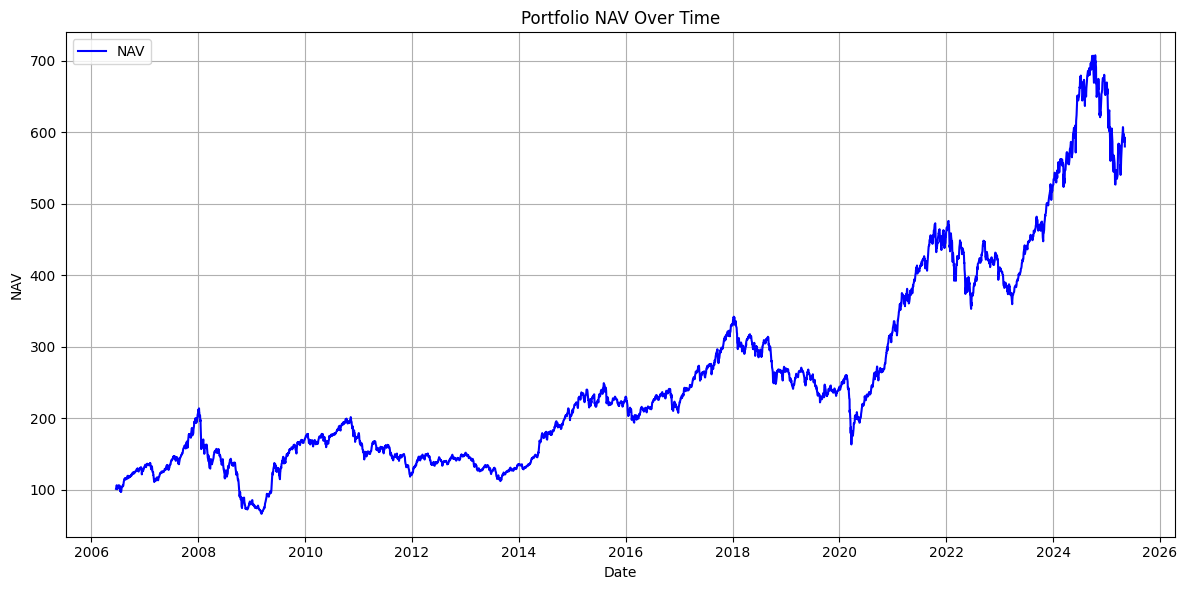

In [24]:
# Step 1: Compute NAV
nav = (1 + nav).cumprod() * 100

# Step 2: Plot NAV
plt.figure(figsize=(12, 6))
plt.plot(nav.index, nav.values, label='NAV', color='blue')
plt.title('Portfolio NAV Over Time')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# Ensure NAV is sorted
nav = nav.sort_index()
daily_returns = nav.pct_change().dropna()

# Compute overall metrics
start_date = nav.index[0]
end_date = nav.index[-1]
days = (end_date - start_date).days
years = days / 365.25

cagr = (nav.iloc[-1] / nav.iloc[0])**(1 / years) - 1
rolling_max = nav.cummax()
drawdown = nav / rolling_max - 1
mdd = drawdown.min()
volatility = daily_returns.std() * np.sqrt(252)
# Calendar Year Returns
cy_returns = nav.resample('Y').last().pct_change().dropna()
cy_returns.index = cy_returns.index.year
cy_df = pd.DataFrame({'CY Return': cy_returns})

# Financial Year Returns (Apr–Mar)
fy_nav = nav.copy()
fy_nav.index = fy_nav.index.to_period('M')
fy_ends = fy_nav.groupby(fy_nav.index.to_timestamp().to_period("A-MAR")).last()
fy_returns = fy_ends.pct_change().dropna()
fy_returns.index = fy_returns.index.year + 1
fy_df = pd.DataFrame({'FY Return': fy_returns})

# Monthly returns
monthly_periods = {
    '1M Return': 21,
    '2M Return': 42,
    '3M Return': 63,
    '6M Return': 126,
    '12M Return': 252,
    '24M Return': 504
}

monthly_data = []
for label, days_back in monthly_periods.items():
    if len(nav) > days_back:
        ret = nav.iloc[-1] / nav.iloc[-days_back] - 1
        monthly_data.append({'Metric': label, 'Value': ret, 'Period': 'Latest'})

# Summary Metrics
summary_df = pd.DataFrame({
    'Metric': ['CAGR', 'Max Drawdown', 'Annualized Volatility'],
    'Value': [cagr, mdd, volatility],
    'Period': 'Overall'
})

# Calendar Year
cy_df_formatted = cy_df.rename_axis('Year').reset_index()
cy_df_formatted['Metric'] = 'CY Return'
cy_df_formatted = cy_df_formatted.rename(columns={'Year': 'Period', 'CY Return': 'Value'})

# Financial Year
fy_df_formatted = fy_df.rename_axis('Year').reset_index()
fy_df_formatted['Metric'] = 'FY Return'
fy_df_formatted = fy_df_formatted.rename(columns={'Year': 'Period', 'FY Return': 'Value'})

# Combine all
final_df = pd.concat([
    summary_df,
    pd.DataFrame(monthly_data),
    cy_df_formatted[['Metric', 'Period', 'Value']],
    fy_df_formatted[['Metric', 'Period', 'Value']]
], ignore_index=True)

# Optional: format as percentage
final_df['Value'] = final_df['Value'].apply(lambda x: f"{x:.2%}")

# Display
print(final_df)

                   Metric    Value   Period
0                    CAGR    9.71%  Overall
1            Max Drawdown  -69.01%  Overall
2   Annualized Volatility   19.82%  Overall
3               1M Return   -0.14%   Latest
4               2M Return   10.01%   Latest
5               3M Return   -0.70%   Latest
6               6M Return  -11.59%   Latest
7              12M Return    0.53%   Latest
8              24M Return   50.56%   Latest
9               CY Return   56.79%     2007
10              CY Return  -60.56%     2008
11              CY Return  110.14%     2009
12              CY Return    3.23%     2010
13              CY Return  -31.74%     2011
14              CY Return   23.69%     2012
15              CY Return   -9.46%     2013
16              CY Return   53.62%     2014
17              CY Return   10.29%     2015
18              CY Return   -5.84%     2016
19              CY Return   53.56%     2017
20              CY Return  -18.71%     2018
21              CY Return  -10.2

In [178]:
# Assuming nav is a pandas Series with Date as index
shortv = nav.to_frame(name='Short_Value')

shortv

,Short_Value
Date,
2006-06-19,101.968371
2006-06-20,101.822529
2006-06-21,104.082849
2006-06-22,106.365199
2006-06-23,107.212297
...,...
2025-04-29,1325.157659
2025-04-30,1307.884339
2025-05-02,1297.499850


In [ ]:
# Combine into one DataFrame
combined = longv.join(shortv)

# Calculate daily percentage changes
combined['Long_Return'] = combined['Long_Value'].pct_change()
combined['Short_Return'] = combined['Short_Value'].pct_change()

# Calculate daily long-short return
combined['LongShort_Return'] = combined['Long_Return'] - combined['Short_Return']

# Drop NaN from first row (because of pct_change)
combined = combined.dropna()

# Create long-short NAV, starting at 100
combined['LongShort_NAV'] = (1 + combined['LongShort_Return']).cumprod() * 100

# Final result
long_short_nav = combined['LongShort_NAV']

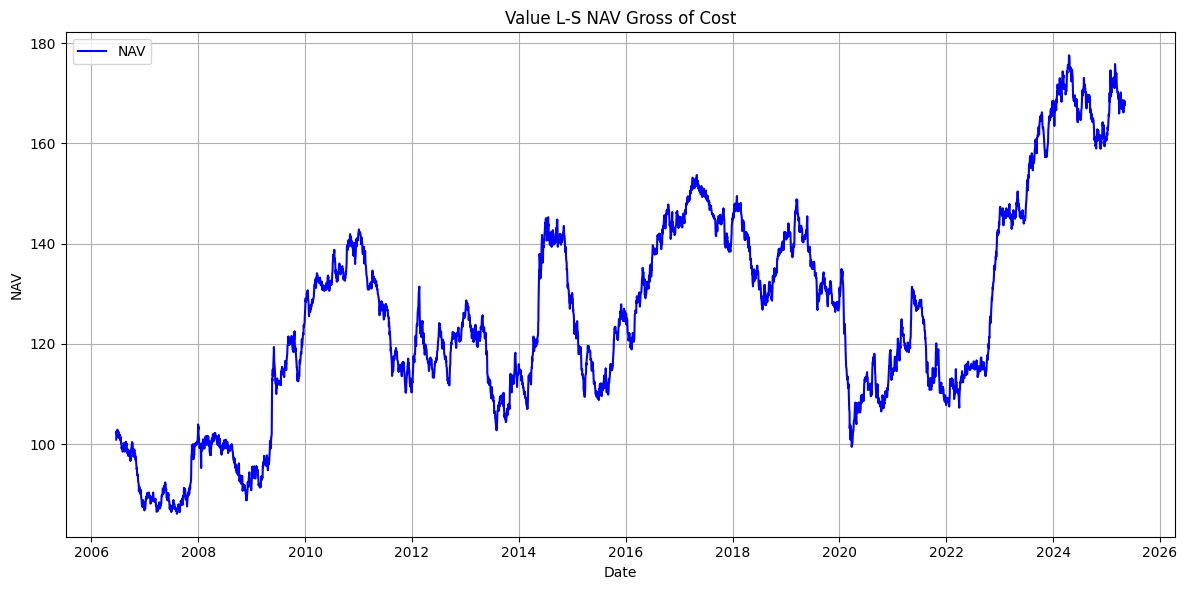

In [189]:
# Step 2: Plot NAV
plt.figure(figsize=(12, 6))
plt.plot(long_short_nav.index, long_short_nav.values, label='NAV', color='blue')
plt.title('Value L-S NAV Gross of Cost')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [190]:
# Ensure NAV is sorted
nav = long_short_nav.sort_index()
daily_returns = nav.pct_change().dropna()

# Compute overall metrics
start_date = nav.index[0]
end_date = nav.index[-1]
days = (end_date - start_date).days
years = days / 365.25

cagr = (nav.iloc[-1] / nav.iloc[0])**(1 / years) - 1
rolling_max = nav.cummax()
drawdown = nav / rolling_max - 1
mdd = drawdown.min()
volatility = daily_returns.std() * np.sqrt(252)
# Calendar Year Returns
cy_returns = nav.resample('Y').last().pct_change().dropna()
cy_returns.index = cy_returns.index.year
cy_df = pd.DataFrame({'CY Return': cy_returns})

# Financial Year Returns (Apr–Mar)
fy_nav = nav.copy()
fy_nav.index = fy_nav.index.to_period('M')
fy_ends = fy_nav.groupby(fy_nav.index.to_timestamp().to_period("A-MAR")).last()
fy_returns = fy_ends.pct_change().dropna()
fy_returns.index = fy_returns.index.year + 1
fy_df = pd.DataFrame({'FY Return': fy_returns})

# Monthly returns
monthly_periods = {
    '1M Return': 21,
    '2M Return': 42,
    '3M Return': 63,
    '6M Return': 126,
    '12M Return': 252,
    '24M Return': 504
}

monthly_data = []
for label, days_back in monthly_periods.items():
    if len(nav) > days_back:
        ret = nav.iloc[-1] / nav.iloc[-days_back] - 1
        monthly_data.append({'Metric': label, 'Value': ret, 'Period': 'Latest'})

# Summary Metrics
summary_df = pd.DataFrame({
    'Metric': ['CAGR', 'Max Drawdown', 'Annualized Volatility'],
    'Value': [cagr, mdd, volatility],
    'Period': 'Overall'
})

# Calendar Year
cy_df_formatted = cy_df.rename_axis('Year').reset_index()
cy_df_formatted['Metric'] = 'CY Return'
cy_df_formatted = cy_df_formatted.rename(columns={'Year': 'Period', 'CY Return': 'Value'})

# Financial Year
fy_df_formatted = fy_df.rename_axis('Year').reset_index()
fy_df_formatted['Metric'] = 'FY Return'
fy_df_formatted = fy_df_formatted.rename(columns={'Year': 'Period', 'FY Return': 'Value'})

# Combine all
final_df = pd.concat([
    summary_df,
    pd.DataFrame(monthly_data),
    cy_df_formatted[['Metric', 'Period', 'Value']],
    fy_df_formatted[['Metric', 'Period', 'Value']]
], ignore_index=True)

# Optional: format as percentage
final_df['Value'] = final_df['Value'].apply(lambda x: f"{x:.2%}")

# Display
print(final_df)

                   Metric    Value   Period
0                    CAGR    2.73%  Overall
1            Max Drawdown  -35.30%  Overall
2   Annualized Volatility   10.59%  Overall
3               1M Return    0.09%   Latest
4               2M Return   -4.66%   Latest
5               3M Return   -2.25%   Latest
6               6M Return    3.29%   Latest
7              12M Return   -4.26%   Latest
8              24M Return   14.70%   Latest
9               CY Return   17.74%     2007
10              CY Return  -10.44%     2008
11              CY Return   37.55%     2009
12              CY Return   12.80%     2010
13              CY Return  -22.30%     2011
14              CY Return   13.90%     2012
15              CY Return   -8.74%     2013
16              CY Return   12.33%     2014
17              CY Return   -3.41%     2015
18              CY Return   15.85%     2016
19              CY Return   -0.05%     2017
20              CY Return   -2.00%     2018
21              CY Return   -9.7

In [27]:
# Assuming nav is a pandas Series with Date as index
nav_df = nav.to_frame(name='AntiValue_ABS')
nav_df

,AntiValue_ABS
Date,
2006-06-19,100.968371
2006-06-20,100.823959
2006-06-21,103.062113
2006-06-22,105.322079
2006-06-23,106.160870
...,...
2025-04-29,597.578142
2025-04-30,589.857496
2025-05-02,586.400553


In [28]:
nav_df.to_csv('AntiValue_ABS.csv')